# Predicting House Prices

Nowadays, housing prices are extremely on the rise due to the increase in demand. It is really hard to get your hands on a house and even if you do, it has become normal to pay much more than the original sales price of the house.

When thinking about the sales price of a house, most people think this is a combination of the size of the lot, the amount of bedrooms and the location. However, many more unfamiliar features determine the sales price of a house. Given a dataset with 79 features, both a mixture of categorical and numerical features, we are going to estimate the value of houses in Ames Iowa. Creating a model which predicts housing prices will help to solve real world problems because housing prices can in this way be computed in a more rational way.

## Import the necessary modules and libraries

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor


## Import data

In [2]:
train_data = pd.read_csv('train.csv')

## Inspect data

In [3]:
# train_data.info()

In [4]:
def show_missing_info(df):
    missing_info = df.isna().sum().reset_index(drop=False)
    missing_info.columns = ["column","rows"]
    missing_info["missing_pct"] = (missing_info["rows"]/train_data.shape[0])*100
    missing_info = missing_info[missing_info["rows"]>0].sort_values(by="missing_pct",ascending=False)
    return missing_info

# missing_df = show_missing_info(train_data)
# print(missing_df)

As the first 5 features ('Alley','PoolQC','Fence','MiscFeature','FireplaceQu') include a lot of missing data, we decided to drop the columns of this features from the data set.

## Visualize sale prices

/Users/miucciasmit/opt/anaconda3/envs/progLab/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

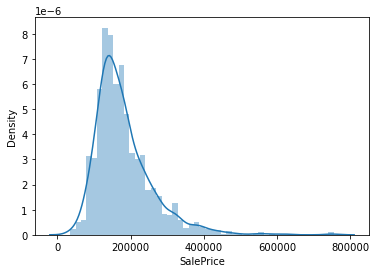

In [5]:
# select the Sale price from the training data = y 
y_train = train_data['SalePrice']
X_train = train_data.iloc[:, :-1]

# create histogram with seaborn of the Sale price (y) from train and test data
sns.distplot(y_train)

## Prepare data

Because it has been discovered that the test data is distributed very differently than the training data, we are going to redivide the data set. In addition, we will make some adjustments in the data set in order to make the data useful as input to the model.

1. One hot encode the categorical data
2. Clean data
    - Replace missing numerical data with the mean value of that feature
    - Replace missing categorical data with the most common category of that feature)
3. Ramdomly devide merged data set into 70% train data and 30% test data? --> validation?

In [6]:
def cleaning(dataframe):
    """
    This function corrects any missing values in a pandas dataframe
    returns the cleaned dataframe
    """
    
    # loop through all the features/columns in the training data
    for column in dataframe:
        
        # if column is in top 5 of columns with most missing data, drop column
        if column in ['Alley','PoolQC','Fence','MiscFeature','FireplaceQu']:
            dataframe.drop[column]
        
        # check whether the data in each column is numerical
        if is_numeric_dtype(dataframe[column]):

            # if the data is numerical compute the mean of the whole column values
            column_mean = dataframe[column].mean()

            # replace the missing values in this column with the mean of the column
            dataframe[column] = dataframe[column].fillna(column_mean)

        # also replace categorical missing values
        # check this approach!
        else:
            dataframe[column] = dataframe[column].fillna(dataframe[column].value_counts().index[0])
    
    return dataframe


## One hot encode categorical data

In [7]:
def one_hot_encoding(df):
    
    """One hot encode categorical data from a dataframe."""
        
    # select all categorical features
    cat_data = df.select_dtypes(include=[object])
    num_data = df.select_dtypes(exclude=[object])
    
    # create a LabelEncoder object and apply it to each categorical feature in the data
    le = preprocessing.LabelEncoder()
    cat_data_2 = cat_data.apply(le.fit_transform)
    
    # create a OneHotEncoder object and fit it to all categorical data
    enc = preprocessing.OneHotEncoder()
    enc.fit(cat_data_2)
    onehotlabels = enc.transform(cat_data_2).toarray()
    
    # get all possible categories from the data
    all_categories = enc.get_feature_names(cat_data_2.columns)

    # create new dataframe with all possible categories as columns
    cat_data = pd.DataFrame(onehotlabels, columns = all_categories)
    
    num_data = num_data.set_index('Id')
    
    # merge the numerical data with the one hot encoded categorical data again
    result = pd.concat([cat_data, num_data], axis=1).reindex(cat_data.index)
        
    return result


# one hot encode categorical data in dataframe
X_train_cleaned = one_hot_encoding(X_train)   
    
# clean data in dataframe
X_train_cleaned = cleaning(X_train_cleaned)

## Divide the dataset

Train and validation set

In [8]:
# split between test data and train data
X_train, X_test, y_train, y_test = train_test_split(X_train_cleaned, y_train, test_size=0.2, random_state=42)



## Regression tree

* Have a look at possible parameters!!!! https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [9]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=5, splitter="best")
regr_1.fit(X_train, y_train)

# Predict
y_pred1 = regr_1.predict(X_test)

# Compute root mean squared error 
rmse = np.sqrt(mean_squared_error(y_pred1, y_test))
print("RMSE:", rmse)

# Visualize the Decision Tree
text_representation = tree.export_text(regr_1)
# print(text_representation)


RMSE: 57539.603292080275


### Determine the optimal max_depth

Optimal max_depth = 6
Optimal RMSE = 55494.77510267733


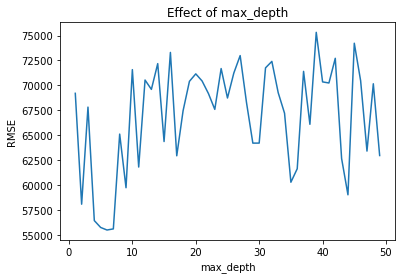

In [10]:
model = DecisionTreeRegressor()
estimators = np.arange(1, 50)
rmses = []
optimal_rmse = float("inf")
optimal_max_depth = 0

for n in estimators:
    
    # Fit regression model
    model.set_params(max_depth=n)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Compute root mean squared error 
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rmses.append(rmse)
    
    if rmse < optimal_rmse:
        optimal_rmse = rmse
        optimal_max_depth = n
        
    
plt.title("Effect of max_depth")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.plot(estimators, rmses)

print(f"Optimal max_depth =", optimal_max_depth)
print(f"Optimal RMSE =", optimal_rmse)


## Random forest regression

In [11]:
regressor = RandomForestRegressor(n_estimators=140, random_state=0)
regressor.fit(X_train.values, y_train)

y_pred = regressor.predict(X_test)

# compute root mean squared error 
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE:", rmse)


RMSE: 46611.972606783056


### Determine the optimal number of estimators

Optimal n_estimators = 10
Optimal RMSE = 45007.414889207765


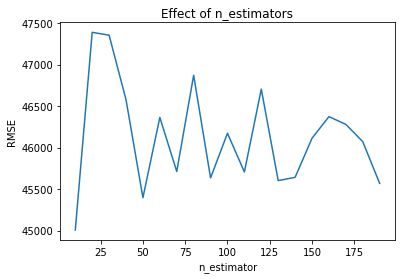

In [12]:
model = RandomForestRegressor()
estimators = np.arange(10, 200, 10)
rmses = []
optimal_rmse = float("inf")
optimal_n_estimators = 0

for n in estimators:
    
    # Fit regression model
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Compute root mean squared error 
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rmses.append(rmse)
    
    if rmse < optimal_rmse:
        optimal_rmse = rmse
        optimal_n_estimators = n
    
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("RMSE")
plt.plot(estimators, rmses)

print(f"Optimal n_estimators =", optimal_n_estimators)
print(f"Optimal RMSE =", optimal_rmse)

## Extra trees

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

In [32]:
#min samples split, max features, max samples, leave nodes and parameter die uitzoekt welke features belangrijk zijn.

clf = ExtraTreesClassifier(n_estimators=160, random_state = 0, max_features = 20) 
                           #min_samples_split = 4, max_leaf_nodes = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE:", rmse )

RMSE: 51129.60263339263
